In [1]:
from environments import ZeroDCleanupEnv
from agents import QAgent
import numpy as np
from collections import defaultdict
import torch
import sys
from tqdm import tqdm

2023-11-21 23:02:11,550	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
np.set_printoptions(threshold=sys.maxsize)

cpu


In [3]:
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]
reward_multiplier = 10

In [4]:
pp = False
verbose = False

In [5]:
num_episodes = 200
verbose_episode = num_episodes - 1
max_steps_per_episode = 1000
state_dim = 4
action_dim = 2

In [6]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [7]:
lr = 0.01
gamma = 0.99
epsilon = 0.5
epsilon_decay = 0.9999
epsilon_min = 0.05
batch_size = 128

In [8]:
env = ZeroDCleanupEnv(agent_ids, 
                      num_agents=num_agents, 
                      area=area, 
                      thresholdDepletion=thresholdDepletion,
                      thresholdRestoration=thresholdRestoration,
                      wasteSpawnProbability=wasteSpawnProbability,
                      appleRespawnProbability=appleRespawnProbability,
                      dirt_multiplier=dirt_multiplier)

agentCoordinator = QAgent(device=device,
                                     num_action_outputs=num_agents,
                                     action_size=action_dim,
                                     state_dim=state_dim,
                                     lr=lr,
                                     gamma=gamma,
                                     epsilon=epsilon,
                                     epsilon_decay=epsilon_decay,
                                     epsilon_min=epsilon_min,
                                     batch_size=batch_size,
                                     q_layers=[
                                         (state_dim, 64),
                                         (64, 32),
                                         #(64, 64),
                                         (32, 32),
                                         (32, action_dim * num_agents)
                                     ],
                                     verbose=False)

In [9]:
ending_ep_rewards = []
weight_graph = defaultdict(list)

In [10]:
import uuid
import os

if not os.path.exists("results"):
    os.mkdir("results")

test_id = uuid.uuid4()
os.mkdir("results/q_simple_" + str(test_id))
f = open("results/q_simple_" + str(test_id) + "/logs.txt", "x")

In [11]:
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")
    f.write(f"========= Episode {episode} =========\n")

    states, info = env.reset()
    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    #state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
    state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        #next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        next_state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])
        reward = sum(rewards.values())
        #reward_graph.append(reward)
        agentCoordinator.step(state, actions_list, reward, next_state)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")
    
    f.write(f"ending reward: {ending_reward}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Episode {episode} =========\n")

    ending_ep_rewards.append(ending_reward)

    if ending_reward > 5000 and ending_ep_rewards[-2] > 5000 and agentCoordinator.epsilon < 0.1:
        break

    

torch.save(agentCoordinator.q_network.state_dict(), "results/q_simple_" + str(test_id) + "/q_network.pt")

        

========= Episode 0 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


 14%|█▍        | 145/1000 [00:00<00:00, 1442.21it/s]

100%|█████████▉| 999/1000 [00:01<00:00, 614.88it/s] 


ending reward: 2599
========= End of Episode 0 =========
========= Episode 1 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 528.50it/s]


ending reward: 2626
========= End of Episode 1 =========
========= Episode 2 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 600.31it/s]


ending reward: 2692
========= End of Episode 2 =========
========= Episode 3 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 600.60it/s]


ending reward: 2581
========= End of Episode 3 =========
========= Episode 4 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 715.27it/s]


ending reward: 2611
========= End of Episode 4 =========
========= Episode 5 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 797.11it/s]


ending reward: 2561
========= End of Episode 5 =========
========= Episode 6 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 621.88it/s]


ending reward: 2649
========= End of Episode 6 =========
========= Episode 7 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 640.18it/s]


ending reward: 2587
========= End of Episode 7 =========
========= Episode 8 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 619.49it/s]


ending reward: 2591
========= End of Episode 8 =========
========= Episode 9 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 678.34it/s]


ending reward: 2485
========= End of Episode 9 =========
========= Episode 10 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 779.93it/s]


ending reward: 2572
========= End of Episode 10 =========
========= Episode 11 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 778.17it/s]


ending reward: 2664
========= End of Episode 11 =========
========= Episode 12 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 808.80it/s]


ending reward: 2514
========= End of Episode 12 =========
========= Episode 13 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 794.35it/s]


ending reward: 2532
========= End of Episode 13 =========
========= Episode 14 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 768.48it/s]


ending reward: 2480
========= End of Episode 14 =========
========= Episode 15 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 769.29it/s]


ending reward: 2482
========= End of Episode 15 =========
========= Episode 16 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 784.16it/s]


ending reward: 2412
========= End of Episode 16 =========
========= Episode 17 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 747.99it/s]


ending reward: 2365
========= End of Episode 17 =========
========= Episode 18 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 811.46it/s]


ending reward: 2316
========= End of Episode 18 =========
========= Episode 19 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.32it/s]


ending reward: 2295
========= End of Episode 19 =========
========= Episode 20 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 759.30it/s]


ending reward: 2122
========= End of Episode 20 =========
========= Episode 21 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 575.97it/s]


ending reward: 1991
========= End of Episode 21 =========
========= Episode 22 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 684.53it/s]


ending reward: 2118
========= End of Episode 22 =========
========= Episode 23 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 592.02it/s]


ending reward: 1850
========= End of Episode 23 =========
========= Episode 24 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 632.57it/s]


ending reward: 1389
========= End of Episode 24 =========
========= Episode 25 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 733.94it/s]


ending reward: 408
========= End of Episode 25 =========
========= Episode 26 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 635.64it/s]


ending reward: 574
========= End of Episode 26 =========
========= Episode 27 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 855.94it/s]


ending reward: 427
========= End of Episode 27 =========
========= Episode 28 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 809.37it/s]


ending reward: 368
========= End of Episode 28 =========
========= Episode 29 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 846.24it/s]


ending reward: 378
========= End of Episode 29 =========
========= Episode 30 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 853.36it/s]


ending reward: 307
========= End of Episode 30 =========
========= Episode 31 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 848.52it/s]


ending reward: 249
========= End of Episode 31 =========
========= Episode 32 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 833.73it/s]


ending reward: 200
========= End of Episode 32 =========
========= Episode 33 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 844.23it/s]


ending reward: 269
========= End of Episode 33 =========
========= Episode 34 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 792.27it/s]


ending reward: 530
========= End of Episode 34 =========
========= Episode 35 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 722.15it/s]


ending reward: 396
========= End of Episode 35 =========
========= Episode 36 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 856.51it/s]


ending reward: 732
========= End of Episode 36 =========
========= Episode 37 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 847.93it/s]


ending reward: 358
========= End of Episode 37 =========
========= Episode 38 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 857.61it/s]


ending reward: 507
========= End of Episode 38 =========
========= Episode 39 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 752.88it/s]


ending reward: 310
========= End of Episode 39 =========
========= Episode 40 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 716.69it/s]


ending reward: 229
========= End of Episode 40 =========
========= Episode 41 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 622.91it/s]


ending reward: 301
========= End of Episode 41 =========
========= Episode 42 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 549.38it/s]


ending reward: 294
========= End of Episode 42 =========
========= Episode 43 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 812.15it/s]


ending reward: 240
========= End of Episode 43 =========
========= Episode 44 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 658.53it/s]


ending reward: 244
========= End of Episode 44 =========
========= Episode 45 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 610.09it/s]


ending reward: 334
========= End of Episode 45 =========
========= Episode 46 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 633.39it/s]


ending reward: 299
========= End of Episode 46 =========
========= Episode 47 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 728.71it/s]


ending reward: 523
========= End of Episode 47 =========
========= Episode 48 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 611.59it/s]


ending reward: 1520
========= End of Episode 48 =========
========= Episode 49 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 627.07it/s]


ending reward: 1486
========= End of Episode 49 =========
========= Episode 50 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 621.91it/s]


ending reward: 856
========= End of Episode 50 =========
========= Episode 51 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 626.63it/s]


ending reward: 893
========= End of Episode 51 =========
========= Episode 52 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 755.06it/s]


ending reward: 692
========= End of Episode 52 =========
========= Episode 53 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 674.65it/s]


ending reward: 468
========= End of Episode 53 =========
========= Episode 54 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 578.85it/s]


ending reward: 617
========= End of Episode 54 =========
========= Episode 55 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 630.75it/s]


ending reward: 443
========= End of Episode 55 =========
========= Episode 56 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 787.00it/s]


ending reward: 319
========= End of Episode 56 =========
========= Episode 57 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 833.88it/s]


ending reward: 979
========= End of Episode 57 =========
========= Episode 58 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 727.44it/s]


ending reward: 933
========= End of Episode 58 =========
========= Episode 59 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 606.96it/s]


ending reward: 700
========= End of Episode 59 =========
========= Episode 60 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 654.58it/s]


ending reward: 912
========= End of Episode 60 =========
========= Episode 61 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 618.83it/s]


ending reward: 1512
========= End of Episode 61 =========
========= Episode 62 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 719.12it/s]


ending reward: 1091
========= End of Episode 62 =========
========= Episode 63 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 698.25it/s]


ending reward: 1333
========= End of Episode 63 =========
========= Episode 64 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 804.98it/s]


ending reward: 1063
========= End of Episode 64 =========
========= Episode 65 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 802.16it/s]


ending reward: 1621
========= End of Episode 65 =========
========= Episode 66 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 629.39it/s]


ending reward: 1215
========= End of Episode 66 =========
========= Episode 67 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 566.58it/s]


ending reward: 1370
========= End of Episode 67 =========
========= Episode 68 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 841.09it/s]


ending reward: 798
========= End of Episode 68 =========
========= Episode 69 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 773.33it/s]


ending reward: 635
========= End of Episode 69 =========
========= Episode 70 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 737.32it/s]


ending reward: 1005
========= End of Episode 70 =========
========= Episode 71 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 653.08it/s]


ending reward: 1272
========= End of Episode 71 =========
========= Episode 72 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 745.75it/s]


ending reward: 1589
========= End of Episode 72 =========
========= Episode 73 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 734.68it/s]


ending reward: 1513
========= End of Episode 73 =========
========= Episode 74 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 835.49it/s]


ending reward: 1079
========= End of Episode 74 =========
========= Episode 75 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 845.16it/s]


ending reward: 2762
========= End of Episode 75 =========
========= Episode 76 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 622.01it/s]


ending reward: 2539
========= End of Episode 76 =========
========= Episode 77 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 863.60it/s]


ending reward: 2486
========= End of Episode 77 =========
========= Episode 78 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 862.51it/s]


ending reward: 1641
========= End of Episode 78 =========
========= Episode 79 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 638.60it/s]


ending reward: 2121
========= End of Episode 79 =========
========= Episode 80 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 792.22it/s]


ending reward: 1940
========= End of Episode 80 =========
========= Episode 81 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.58it/s]


ending reward: 2031
========= End of Episode 81 =========
========= Episode 82 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 859.57it/s]


ending reward: 2180
========= End of Episode 82 =========
========= Episode 83 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 640.54it/s]


ending reward: 2084
========= End of Episode 83 =========
========= Episode 84 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 677.19it/s]


ending reward: 1406
========= End of Episode 84 =========
========= Episode 85 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 665.48it/s]


ending reward: 2503
========= End of Episode 85 =========
========= Episode 86 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 639.16it/s]


ending reward: 2602
========= End of Episode 86 =========
========= Episode 87 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 757.27it/s]


ending reward: 1994
========= End of Episode 87 =========
========= Episode 88 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 572.12it/s]


ending reward: 2255
========= End of Episode 88 =========
========= Episode 89 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 642.50it/s]


ending reward: 2073
========= End of Episode 89 =========
========= Episode 90 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 627.42it/s]


ending reward: 1882
========= End of Episode 90 =========
========= Episode 91 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 663.08it/s]


ending reward: 1801
========= End of Episode 91 =========
========= Episode 92 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 531.09it/s]


ending reward: 2711
========= End of Episode 92 =========
========= Episode 93 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 754.25it/s]


ending reward: 2202
========= End of Episode 93 =========
========= Episode 94 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 650.56it/s]


ending reward: 1967
========= End of Episode 94 =========
========= Episode 95 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 603.63it/s]


ending reward: 2549
========= End of Episode 95 =========
========= Episode 96 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 554.85it/s]


ending reward: 1798
========= End of Episode 96 =========
========= Episode 97 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 617.41it/s]


ending reward: 2246
========= End of Episode 97 =========
========= Episode 98 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 631.19it/s]


ending reward: 2603
========= End of Episode 98 =========
========= Episode 99 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 574.69it/s]


ending reward: 979
========= End of Episode 99 =========
========= Episode 100 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 551.50it/s]


ending reward: 2058
========= End of Episode 100 =========
========= Episode 101 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 588.71it/s]


ending reward: 2663
========= End of Episode 101 =========
========= Episode 102 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 583.38it/s]


ending reward: 2367
========= End of Episode 102 =========
========= Episode 103 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 596.99it/s]


ending reward: 1676
========= End of Episode 103 =========
========= Episode 104 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 599.14it/s]


ending reward: 1804
========= End of Episode 104 =========
========= Episode 105 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 590.60it/s]


ending reward: 2520
========= End of Episode 105 =========
========= Episode 106 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 603.46it/s]


ending reward: 2081
========= End of Episode 106 =========
========= Episode 107 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 537.30it/s]


ending reward: 2330
========= End of Episode 107 =========
========= Episode 108 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 646.06it/s]


ending reward: 2465
========= End of Episode 108 =========
========= Episode 109 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 567.12it/s]


ending reward: 1505
========= End of Episode 109 =========
========= Episode 110 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 629.95it/s]


ending reward: 2232
========= End of Episode 110 =========
========= Episode 111 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 629.59it/s]


ending reward: 2642
========= End of Episode 111 =========
========= Episode 112 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 598.30it/s]


ending reward: 2209
========= End of Episode 112 =========
========= Episode 113 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 791.83it/s]


ending reward: 747
========= End of Episode 113 =========
========= Episode 114 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 638.95it/s]


ending reward: 441
========= End of Episode 114 =========
========= Episode 115 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 749.83it/s]


ending reward: 428
========= End of Episode 115 =========
========= Episode 116 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 686.04it/s]


ending reward: 899
========= End of Episode 116 =========
========= Episode 117 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 638.84it/s]


ending reward: 2718
========= End of Episode 117 =========
========= Episode 118 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 703.39it/s]


ending reward: 2546
========= End of Episode 118 =========
========= Episode 119 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 770.94it/s]


ending reward: 2339
========= End of Episode 119 =========
========= Episode 120 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 703.13it/s]


ending reward: 1942
========= End of Episode 120 =========
========= Episode 121 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 769.75it/s]


ending reward: 858
========= End of Episode 121 =========
========= Episode 122 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 777.59it/s]


ending reward: 2582
========= End of Episode 122 =========
========= Episode 123 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 816.34it/s]


ending reward: 2688
========= End of Episode 123 =========
========= Episode 124 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 639.78it/s]


ending reward: 2651
========= End of Episode 124 =========
========= Episode 125 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 604.55it/s]


ending reward: 2477
========= End of Episode 125 =========
========= Episode 126 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 776.71it/s]


ending reward: 1383
========= End of Episode 126 =========
========= Episode 127 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 640.28it/s]


ending reward: 2137
========= End of Episode 127 =========
========= Episode 128 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 624.83it/s]


ending reward: 2769
========= End of Episode 128 =========
========= Episode 129 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 734.15it/s]


ending reward: 2397
========= End of Episode 129 =========
========= Episode 130 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 761.91it/s]


ending reward: 840
========= End of Episode 130 =========
========= Episode 131 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 797.82it/s]


ending reward: 316
========= End of Episode 131 =========
========= Episode 132 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 831.27it/s]


ending reward: 1146
========= End of Episode 132 =========
========= Episode 133 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 774.33it/s]


ending reward: 2471
========= End of Episode 133 =========
========= Episode 134 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 769.37it/s]


ending reward: 2672
========= End of Episode 134 =========
========= Episode 135 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 669.44it/s]


ending reward: 2444
========= End of Episode 135 =========
========= Episode 136 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 537.15it/s]


ending reward: 1906
========= End of Episode 136 =========
========= Episode 137 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 471.79it/s]


ending reward: 577
========= End of Episode 137 =========
========= Episode 138 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 449.18it/s]


ending reward: 57
========= End of Episode 138 =========
========= Episode 139 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 518.73it/s]


ending reward: 43
========= End of Episode 139 =========
========= Episode 140 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 451.00it/s]


ending reward: 43
========= End of Episode 140 =========
========= Episode 141 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 657.95it/s]


ending reward: 47
========= End of Episode 141 =========
========= Episode 142 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 734.92it/s]


ending reward: 111
========= End of Episode 142 =========
========= Episode 143 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 738.85it/s]


ending reward: 1945
========= End of Episode 143 =========
========= Episode 144 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 609.06it/s]


ending reward: 2061
========= End of Episode 144 =========
========= Episode 145 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 518.09it/s]


ending reward: 2143
========= End of Episode 145 =========
========= Episode 146 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 553.17it/s]


ending reward: 1437
========= End of Episode 146 =========
========= Episode 147 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 619.20it/s]


ending reward: 1014
========= End of Episode 147 =========
========= Episode 148 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 560.37it/s]


ending reward: 713
========= End of Episode 148 =========
========= Episode 149 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 476.04it/s]


ending reward: 2302
========= End of Episode 149 =========
========= Episode 150 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 582.24it/s]


ending reward: 2244
========= End of Episode 150 =========
========= Episode 151 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 571.42it/s]


ending reward: 2180
========= End of Episode 151 =========
========= Episode 152 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 558.56it/s]


ending reward: 1598
========= End of Episode 152 =========
========= Episode 153 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 692.01it/s]


ending reward: 1833
========= End of Episode 153 =========
========= Episode 154 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 865.71it/s]


ending reward: 2612
========= End of Episode 154 =========
========= Episode 155 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 814.87it/s]


ending reward: 2431
========= End of Episode 155 =========
========= Episode 156 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 746.22it/s]


ending reward: 1374
========= End of Episode 156 =========
========= Episode 157 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 857.70it/s]


ending reward: 1467
========= End of Episode 157 =========
========= Episode 158 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.81it/s]


ending reward: 2323
========= End of Episode 158 =========
========= Episode 159 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 692.69it/s]


ending reward: 1796
========= End of Episode 159 =========
========= Episode 160 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.46it/s]


ending reward: 1811
========= End of Episode 160 =========
========= Episode 161 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 625.40it/s]


ending reward: 2135
========= End of Episode 161 =========
========= Episode 162 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 747.87it/s]


ending reward: 2008
========= End of Episode 162 =========
========= Episode 163 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 867.45it/s]


ending reward: 1476
========= End of Episode 163 =========
========= Episode 164 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 645.74it/s]


ending reward: 82
========= End of Episode 164 =========
========= Episode 165 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 683.70it/s]


ending reward: 39
========= End of Episode 165 =========
========= Episode 166 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 688.29it/s]


ending reward: 298
========= End of Episode 166 =========
========= Episode 167 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 635.97it/s]


ending reward: 1843
========= End of Episode 167 =========
========= Episode 168 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 657.16it/s]


ending reward: 1862
========= End of Episode 168 =========
========= Episode 169 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 626.72it/s]


ending reward: 1746
========= End of Episode 169 =========
========= Episode 170 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 634.83it/s]


ending reward: 1633
========= End of Episode 170 =========
========= Episode 171 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 675.73it/s]


ending reward: 910
========= End of Episode 171 =========
========= Episode 172 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 392.47it/s]


ending reward: 1724
========= End of Episode 172 =========
========= Episode 173 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 694.09it/s]


ending reward: 2320
========= End of Episode 173 =========
========= Episode 174 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 554.20it/s]


ending reward: 2284
========= End of Episode 174 =========
========= Episode 175 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 492.05it/s]


ending reward: 1190
========= End of Episode 175 =========
========= Episode 176 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 486.41it/s]


ending reward: 2017
========= End of Episode 176 =========
========= Episode 177 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 540.74it/s]


ending reward: 2407
========= End of Episode 177 =========
========= Episode 178 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 548.02it/s]


ending reward: 1157
========= End of Episode 178 =========
========= Episode 179 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 685.83it/s]


ending reward: 2468
========= End of Episode 179 =========
========= Episode 180 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 725.97it/s]


ending reward: 2543
========= End of Episode 180 =========
========= Episode 181 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 684.66it/s]


ending reward: 2055
========= End of Episode 181 =========
========= Episode 182 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 657.43it/s]


ending reward: 2092
========= End of Episode 182 =========
========= Episode 183 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 662.34it/s]


ending reward: 2088
========= End of Episode 183 =========
========= Episode 184 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 594.81it/s]


ending reward: 1794
========= End of Episode 184 =========
========= Episode 185 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 817.57it/s]


ending reward: 2594
========= End of Episode 185 =========
========= Episode 186 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 719.61it/s]


ending reward: 2245
========= End of Episode 186 =========
========= Episode 187 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 755.90it/s]


ending reward: 1393
========= End of Episode 187 =========
========= Episode 188 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 684.15it/s]


ending reward: 2620
========= End of Episode 188 =========
========= Episode 189 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 699.45it/s]


ending reward: 2669
========= End of Episode 189 =========
========= Episode 190 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 655.39it/s]


ending reward: 1845
========= End of Episode 190 =========
========= Episode 191 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 607.23it/s]


ending reward: 2490
========= End of Episode 191 =========
========= Episode 192 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 696.88it/s]


ending reward: 2725
========= End of Episode 192 =========
========= Episode 193 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 462.27it/s]


ending reward: 1750
========= End of Episode 193 =========
========= Episode 194 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 564.36it/s]


ending reward: 1963
========= End of Episode 194 =========
========= Episode 195 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 581.53it/s]


ending reward: 2432
========= End of Episode 195 =========
========= Episode 196 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 688.95it/s]


ending reward: 2125
========= End of Episode 196 =========
========= Episode 197 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 450.79it/s]


ending reward: 1633
========= End of Episode 197 =========
========= Episode 198 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 526.96it/s]


ending reward: 989
========= End of Episode 198 =========
========= Episode 199 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 568.09it/s]

ending reward: 1923
========= End of Episode 199 =========


In [21]:
test_stats = []
num_test_episodes = 15
print("========= Testing =========")
f.write("========= Testing =========\n")

for episode in range(num_test_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    #state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
    state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        #next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        next_state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])
        reward = sum(rewards.values())
        #reward_graph.append(reward)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    print(f"ending info: {info}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Test =========")

    f.write(f"ending info: {info}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Test =========\n")

    test_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = test_reward

    print(test_reward)

========= Testing =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5096.29it/s]


ending info: {'total_apple_consumed': 2675, 'step_apple_consumed': 2, 'apple': 75, 'dirt': 18, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 13, '3': 93, '2': 274, '5': 8, '8': 10, '7': 12, '4': 18, '0': 545, '6': 785, '1': 917}}
========= End of Test =========
2675
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4159.28it/s]


ending info: {'total_apple_consumed': 2702, 'step_apple_consumed': 2, 'apple': 83, 'dirt': 19, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 12, '3': 87, '2': 275, '5': 7, '8': 11, '7': 9, '4': 15, '0': 574, '6': 802, '1': 910}}
========= End of Test =========
2702
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3896.99it/s]


ending info: {'total_apple_consumed': 2726, 'step_apple_consumed': 4, 'apple': 74, 'dirt': 13, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 10, '3': 76, '2': 273, '5': 7, '8': 8, '7': 16, '4': 15, '0': 582, '6': 816, '1': 923}}
========= End of Test =========
2726
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3953.18it/s]


ending info: {'total_apple_consumed': 2713, 'step_apple_consumed': 0, 'apple': 66, 'dirt': 18, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 9, '3': 76, '2': 281, '5': 13, '8': 12, '7': 15, '4': 19, '0': 574, '6': 801, '1': 913}}
========= End of Test =========
2713
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5339.22it/s]


ending info: {'total_apple_consumed': 2690, 'step_apple_consumed': 2, 'apple': 63, 'dirt': 19, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 8, '3': 88, '2': 281, '5': 6, '8': 15, '7': 15, '4': 13, '0': 561, '6': 788, '1': 915}}
========= End of Test =========
2690
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5026.56it/s]


ending info: {'total_apple_consumed': 2654, 'step_apple_consumed': 3, 'apple': 80, 'dirt': 16, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 10, '3': 66, '2': 265, '5': 4, '8': 9, '7': 8, '4': 14, '0': 546, '6': 806, '1': 926}}
========= End of Test =========
2654
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5076.71it/s]


ending info: {'total_apple_consumed': 2756, 'step_apple_consumed': 3, 'apple': 75, 'dirt': 15, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 12, '3': 85, '2': 282, '5': 4, '8': 10, '7': 11, '4': 10, '0': 580, '6': 829, '1': 933}}
========= End of Test =========
2756
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5815.88it/s]


ending info: {'total_apple_consumed': 2730, 'step_apple_consumed': 5, 'apple': 87, 'dirt': 13, 'picker': 7, 'cleaner': 3, 'total_reward_by_agent': {'9': 13, '3': 85, '2': 273, '5': 6, '8': 8, '7': 19, '4': 21, '0': 561, '6': 809, '1': 935}}
========= End of Test =========
2730
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5868.36it/s]


ending info: {'total_apple_consumed': 2699, 'step_apple_consumed': 4, 'apple': 79, 'dirt': 20, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 11, '3': 90, '2': 283, '5': 5, '8': 7, '7': 11, '4': 14, '0': 562, '6': 798, '1': 918}}
========= End of Test =========
2699
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5925.12it/s]


ending info: {'total_apple_consumed': 2736, 'step_apple_consumed': 3, 'apple': 79, 'dirt': 13, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 8, '3': 95, '2': 285, '5': 7, '8': 5, '7': 6, '4': 14, '0': 581, '6': 809, '1': 926}}
========= End of Test =========
2736
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5939.50it/s]


ending info: {'total_apple_consumed': 2719, 'step_apple_consumed': 4, 'apple': 68, 'dirt': 20, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 14, '3': 81, '2': 269, '5': 4, '8': 7, '7': 7, '4': 17, '0': 573, '6': 823, '1': 924}}
========= End of Test =========
2719
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5432.51it/s]


ending info: {'total_apple_consumed': 2658, 'step_apple_consumed': 1, 'apple': 77, 'dirt': 17, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 12, '3': 74, '2': 268, '5': 8, '8': 6, '7': 11, '4': 12, '0': 558, '6': 781, '1': 928}}
========= End of Test =========
2658
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4106.67it/s]


ending info: {'total_apple_consumed': 2735, 'step_apple_consumed': 2, 'apple': 66, 'dirt': 24, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 14, '3': 81, '2': 283, '5': 2, '8': 7, '7': 15, '4': 14, '0': 576, '6': 817, '1': 926}}
========= End of Test =========
2735
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5501.43it/s]


ending info: {'total_apple_consumed': 2587, 'step_apple_consumed': 1, 'apple': 65, 'dirt': 27, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 6, '3': 58, '2': 245, '5': 8, '8': 11, '7': 15, '4': 18, '0': 525, '6': 785, '1': 916}}
========= End of Test =========
2587
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'9': 0, '3': 0, '2': 0, '5': 0, '8': 0, '7': 0, '4': 0, '0': 0, '6': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5395.77it/s]

ending info: {'total_apple_consumed': 2683, 'step_apple_consumed': 5, 'apple': 72, 'dirt': 16, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'9': 12, '3': 79, '2': 259, '5': 9, '8': 11, '7': 13, '4': 19, '0': 563, '6': 804, '1': 914}}
========= End of Test =========
2683


In [13]:
import matplotlib.pyplot as plt

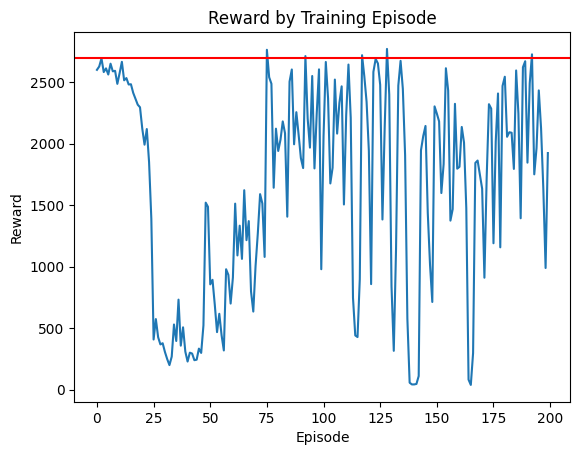

In [22]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.axhline(y=2695.57, color='r', linestyle='-')
plt.show()

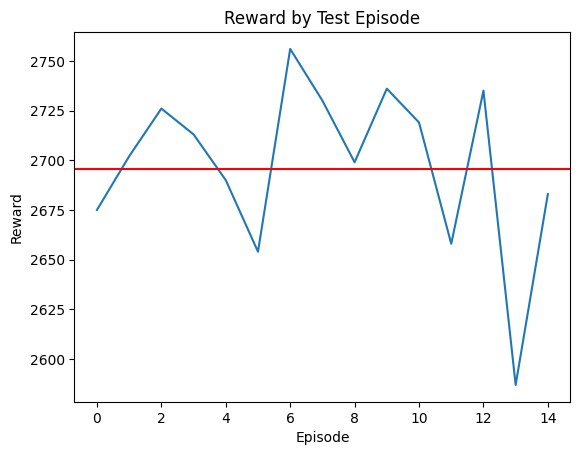

In [23]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.axhline(y=2695.57, color='r', linestyle='-')
plt.show()

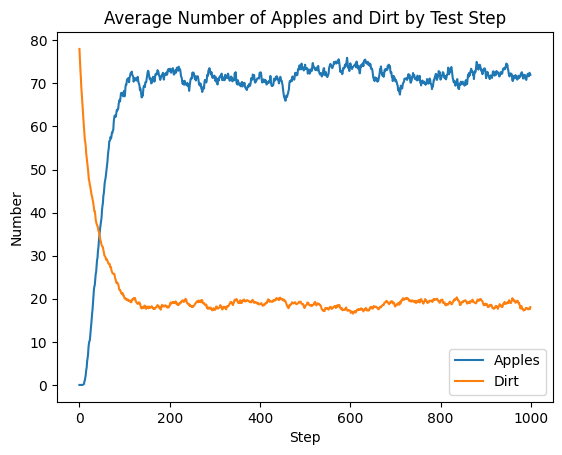

In [16]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(max_steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

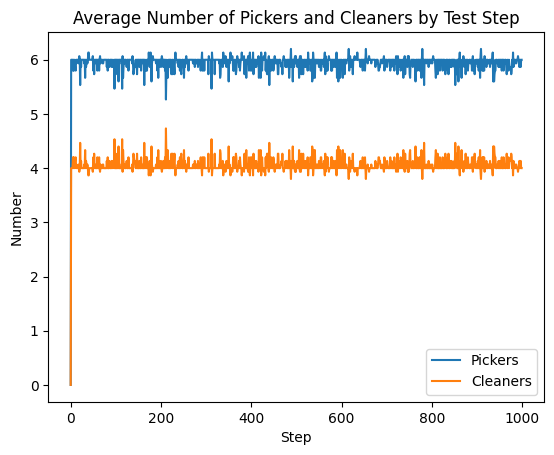

In [17]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(max_steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

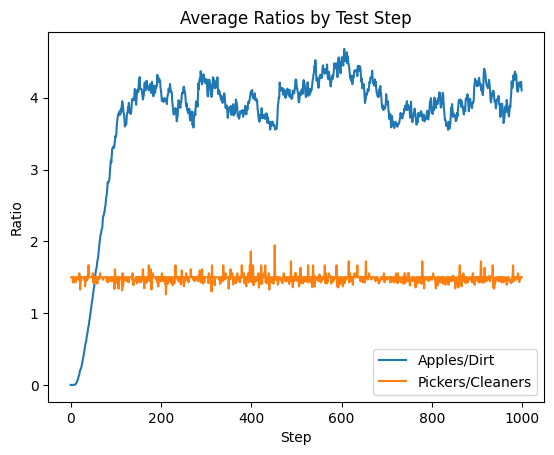

In [18]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(max_steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps, avg_apple_dirt_ratios, label="Apples/Dirt")
plt.plot(picker_cleaner_steps, avg_picker_cleaner_ratios, label="Pickers/Cleaners")
plt.legend()
plt.show()